In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)

import seaborn as sns
from scipy import stats
!pip install statsmodels
import statsmodels.api as sm
import time

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
app_train = pd.read_csv("app_train_red.csv", index_col = 0)
app_test = pd.read_csv("app_test_red.csv")
prev_app = pd.read_csv("previous_application.csv")
install_pmts = pd.read_csv("installments_payments.csv")

In [ ]:
prev_app.AMT_DOWN_PAYMENT.fillna(0, inplace = True)
prev_app.head(15)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,0.0,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,0.0,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,0.0,NaN,MONDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,0.0,NaN,MONDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,0.0,NaN,SATURDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_app.NAME_CONTRACT_STATUS.value_counts()

In [ ]:
# Were current customers approved for a previous loan?
print(app_train.SK_ID_CURR.isin(prev_app.SK_ID_CURR).value_counts())
print(app_test.SK_ID_CURR.isin(prev_app.SK_ID_CURR).value_counts())

True     291057
False     16454
Name: SK_ID_CURR, dtype: int64
True     47800
False      944
Name: SK_ID_CURR, dtype: int64


Not everyone has previously applied for a credit line from Home Credit thus there are quite a few new borrowers, 16454 in fact. Makes sense given the areas Home Credit usually services, meaning since they primarily service Asian countries which tend to be largely cash based blah blah something about them not really using banks and there being the potential for a lot of new customers for lenders (emerging new markets).

In [ ]:
# How many have the current customers applied for loans before? What is their approval rate?
approval_rate = prev_app.groupby("SK_ID_CURR").NAME_CONTRACT_STATUS.agg(total_apps = "count").reset_index()
approval_rate.total_apps

0         1
1         1
2         3
3         1
4         2
         ..
338852    1
338853    1
338854    2
338855    2
338856    8
Name: total_apps, Length: 338857, dtype: int64

In [ ]:
approval_rate = pd.pivot_table(prev_app, index = ["SK_ID_CURR"], columns = ["NAME_CONTRACT_STATUS"], values = "AMT_ANNUITY", aggfunc = len, fill_value=0)

In [ ]:
rates = approval_rate.apply(lambda x: x/sum(x), axis = 1)
rates.columns = rates.columns + "_rate"

In [ ]:
approval_rate["total_apps"] = approval_rate.sum(axis = 1)
approval_rate
approval_rate = approval_rate.join(rates)

In [ ]:
approval_rate = approval_rate.reset_index()
approval_rate.head()

NAME_CONTRACT_STATUS,SK_ID_CURR,Approved,Canceled,Refused,Unused offer,total_apps,Approved_rate,Canceled_rate,Refused_rate,Unused offer_rate
0,100001,1,0,0,0,1,1.0,0.0,0.0,0.0
1,100002,1,0,0,0,1,1.0,0.0,0.0,0.0
2,100003,3,0,0,0,3,1.0,0.0,0.0,0.0
3,100004,1,0,0,0,1,1.0,0.0,0.0,0.0
4,100005,1,1,0,0,2,0.5,0.5,0.0,0.0


In [ ]:
# Does the current customer have a previous loan with Home Credit (ie do they have data in the previous application dataset)
has_prev_app =  pd.DataFrame(app_train.SK_ID_CURR.isin(prev_app.SK_ID_CURR))
has_prev_app.columns = [ "previously_applied"]
app_train['previously_applied'] = has_prev_app

# Converts boolean columns into columns with 0s and 1s
# pd.DataFrame(app_train.SK_ID_CURR.isin(prev_app.SK_ID_CURR)).astype(int)  

In [ ]:
app_train = app_train.join(approval_rate[["SK_ID_CURR", "total_apps", "Approved_rate"]].set_index("SK_ID_CURR"), on = "SK_ID_CURR")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,previously_applied,total_apps,Approved_rate
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,True,1.0,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,True,3.0,1.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,True,1.0,1.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,True,9.0,0.555556
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,True,6.0,1.000000


In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,previously_applied,total_apps,Approved_rate
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,True,1.0,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,True,3.0,1.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,True,1.0,1.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,True,9.0,0.555556
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,True,6.0,1.000000


In [ ]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NAME_CLIENT_TYPE', ylabel='count'>

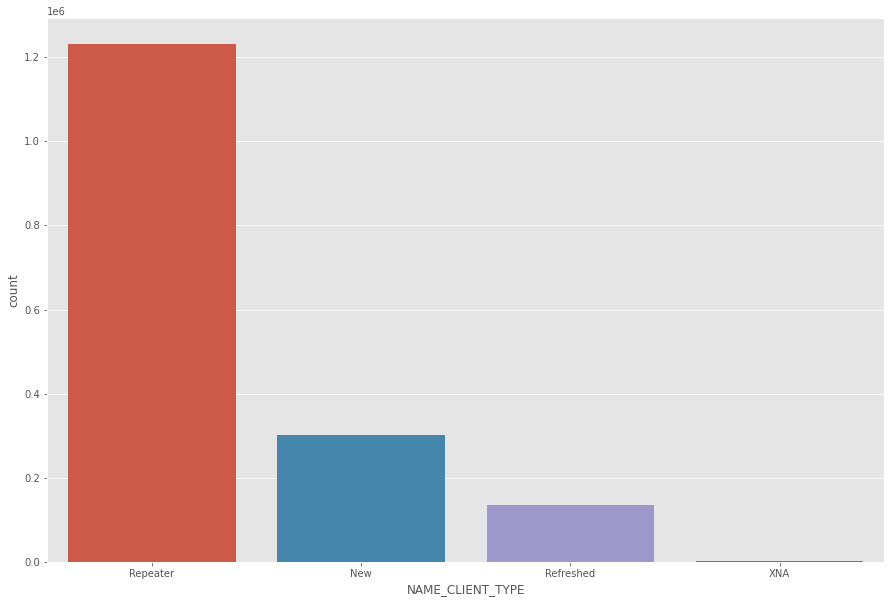

In [ ]:
sns.countplot(prev_app.NAME_CLIENT_TYPE)

In [ ]:
client_type = pd.DataFrame(prev_app.NAME_CLIENT_TYPE == "New")
client_type.columns = ["repeat_client"]
client_type.repeat_client = client_type.repeat_client == False
client_type["SK_ID_CURR"] = prev_app.SK_ID_CURR

In [ ]:
prev_app.groupby(["SK_ID_CURR", "NAME_CLIENT_TYPE"]).NAME_CLIENT_TYPE.agg(count="count").reset_index()

,SK_ID_CURR,NAME_CLIENT_TYPE,count
0,100001,Refreshed,1
1,100002,New,1
2,100003,Refreshed,2
3,100003,Repeater,1
4,100004,New,1
...,...,...,...
623120,456253,Repeater,1
623121,456254,New,1
623122,456254,Repeater,1
623123,456255,Refreshed,1


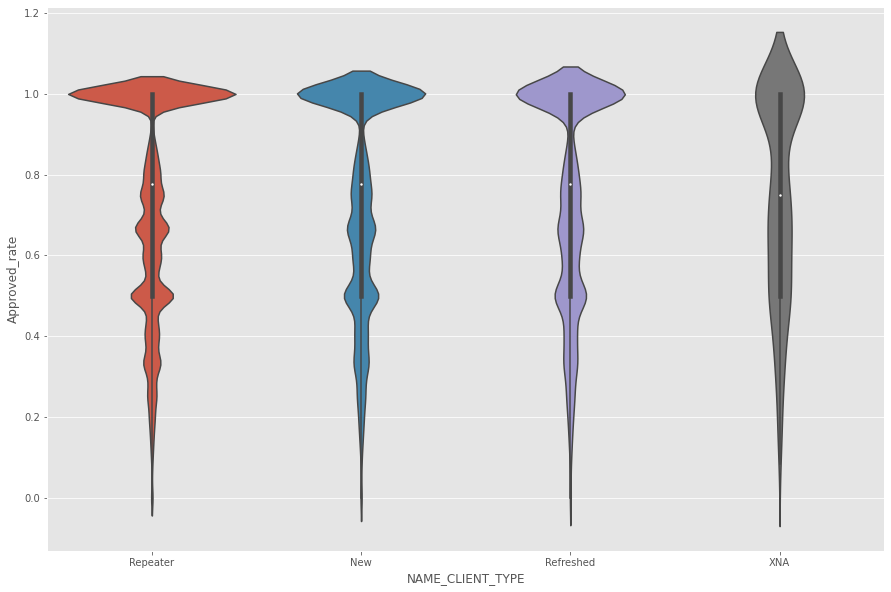

In [ ]:
sns.violinplot(x = prev_app.NAME_CLIENT_TYPE, y = approval_rate.Approved_rate)
plt.show()

In [ ]:
prev_app.sort_values("SK_ID_CURR").head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
575941,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
1021650,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
1223745,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0


[[ 1.         -0.54895953]
 [-0.54895953  1.        ]]


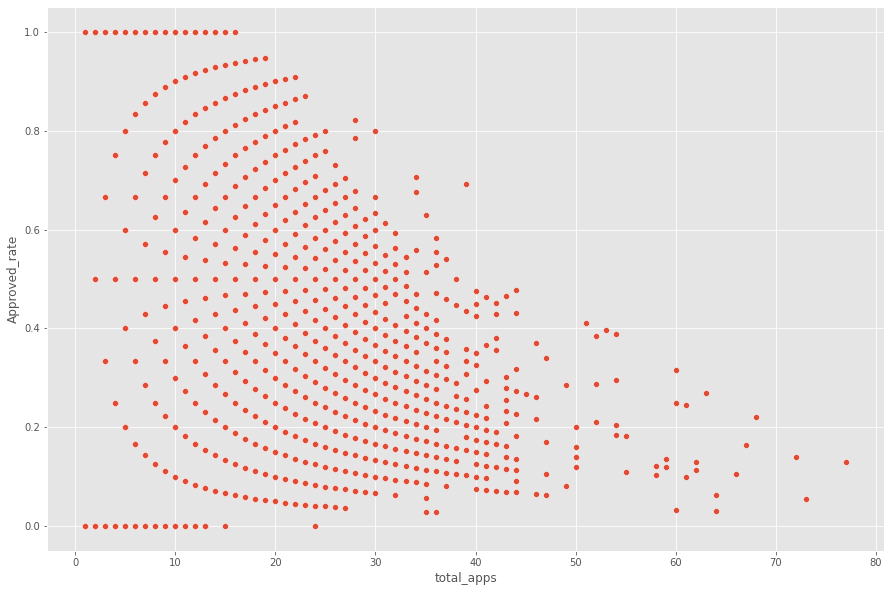

In [ ]:
# Weird patters. There seem to be circular patters, perhaps corresponding to groups when comparing the total number of applications a 
    # client submitted vs the approval rate of their applications. As expected, generally, the more applications are submitted, the lower the approval rate
sns.scatterplot(x =  approval_rate.total_apps, y = approval_rate.Approved_rate)
print(np.corrcoef(approval_rate.total_apps, approval_rate.Approved_rate))

<AxesSubplot:xlabel='total_apps', ylabel='Approved_rate'>

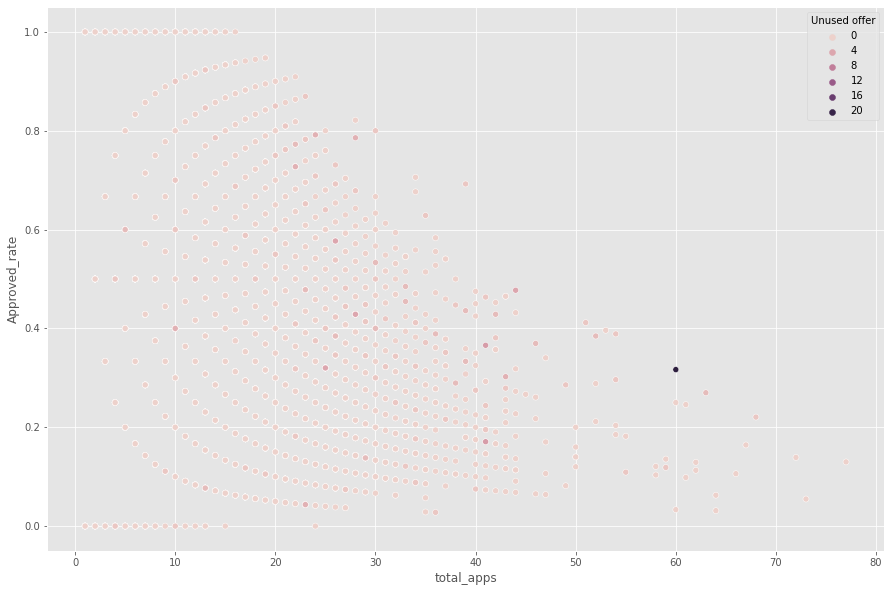

In [ ]:
# There is an odd duck that submitted a lot of applications of which a large percentage were approved, but also had a lot of unused offers. Wonder why
sns.scatterplot(x = approval_rate.total_apps, y = approval_rate.Approved_rate, hue = approval_rate["Unused offer"])

#### Investigating Payments

Attempting to discern if there is any interest paid during the loan, which there should be.

In [ ]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pmts = prev_app[["NAME_CONTRACT_STATUS", "AMT_APPLICATION", "AMT_ANNUITY", "AMT_CREDIT", "CNT_PAYMENT", "AMT_DOWN_PAYMENT", "RATE_DOWN_PAYMENT", "RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED"]]
pmts["term_plus_annuity"] = pmts.AMT_ANNUITY.mul(pmts.CNT_PAYMENT) + pmts.AMT_DOWN_PAYMENT
pmts["interest_paid"] = pmts.term_plus_annuity - pmts.AMT_CREDIT
pmts["int_rate"] = pmts.interest_paid.div( pmts.AMT_CREDIT )
pmts.head(10)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,NAME_CONTRACT_STATUS,AMT_APPLICATION,AMT_ANNUITY,AMT_CREDIT,CNT_PAYMENT,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,term_plus_annuity,interest_paid,int_rate
0,Approved,17145.0,1730.430,17145.0,12.0,0.0,0.0,0.182832,0.867336,20765.16,3620.16,0.211150
1,Approved,607500.0,25188.615,679671.0,36.0,0.0,NaN,NaN,NaN,906790.14,227119.14,0.334160
2,Approved,112500.0,15060.735,136444.5,12.0,0.0,NaN,NaN,NaN,180728.82,44284.32,0.324559
3,Approved,450000.0,47041.335,470790.0,12.0,0.0,NaN,NaN,NaN,564496.02,93706.02,0.199040
4,Refused,337500.0,31924.395,404055.0,24.0,0.0,NaN,NaN,NaN,766185.48,362130.48,0.896241
5,Approved,315000.0,23703.930,340573.5,18.0,0.0,NaN,NaN,NaN,426670.74,86097.24,0.252801
6,Canceled,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,Canceled,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Canceled,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Canceled,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


- The amount paid out during the loan calculated by mulitpying the amount annuity with the number of payments yields some incredibly unreasonable results. 
- In some cases, the "interest paid" is more than the actual loan itself
    - I am assuming Home Credit is taking advantage of these people

<AxesSubplot:xlabel='interest_paid', ylabel='Count'>

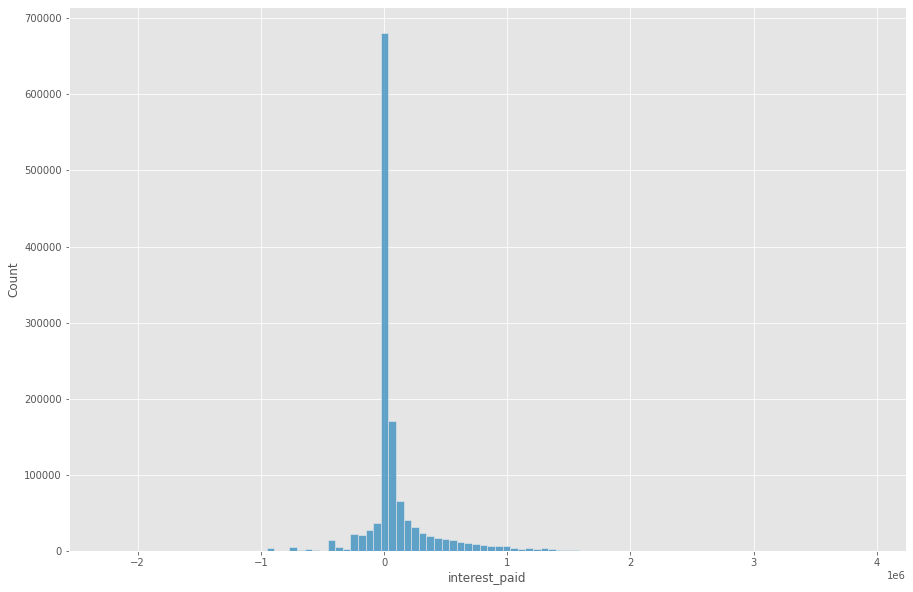

In [ ]:
sns.histplot(pmts.interest_paid, bins = 100)

In [ ]:
pmts[ (pmts.interest_paid <= 0) & (prev_app.CNT_PAYMENT > 0)]

,NAME_CONTRACT_STATUS,AMT_APPLICATION,AMT_ANNUITY,AMT_CREDIT,CNT_PAYMENT,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,term_plus_annuity,interest_paid,int_rate
5749,Refused,0.0,0.0,0.0,60.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
18671,Refused,0.0,0.0,0.0,18.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
60376,Refused,0.0,0.0,0.0,60.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
85052,Refused,0.0,0.0,0.0,18.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
177286,Refused,0.0,0.0,0.0,60.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
260713,Refused,0.0,0.0,0.0,18.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
313995,Refused,0.0,0.0,0.0,12.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
406592,Refused,0.0,0.0,0.0,36.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
411431,Refused,0.0,0.0,0.0,12.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
427400,Refused,0.0,0.0,0.0,12.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN


In [ ]:
prev_app[ (pmts.interest_paid <= 0) & (prev_app.CNT_PAYMENT > 0)]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
5749,2634649,177607,Cash loans,0.000,0.0,0.0,NaN,0.0,MONDAY,13,...,XNA,60.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
18671,2686494,439587,Cash loans,0.000,0.0,0.0,NaN,0.0,MONDAY,10,...,Connectivity,18.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
60376,1166639,120238,Cash loans,0.000,0.0,0.0,NaN,0.0,THURSDAY,14,...,Consumer electronics,60.0,low_action,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
85052,2289455,184083,Cash loans,0.000,0.0,0.0,NaN,0.0,TUESDAY,11,...,XNA,18.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
177286,1525357,313676,Cash loans,0.000,0.0,0.0,NaN,0.0,THURSDAY,10,...,XNA,60.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
260713,1432435,362411,Cash loans,0.000,0.0,0.0,NaN,0.0,WEDNESDAY,10,...,XNA,18.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
313995,1346105,180092,Cash loans,0.000,0.0,0.0,NaN,0.0,FRIDAY,16,...,XNA,12.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
406592,1727975,233622,Cash loans,0.000,0.0,0.0,NaN,0.0,MONDAY,10,...,XNA,36.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
411431,2694280,429698,Cash loans,0.000,0.0,0.0,NaN,0.0,TUESDAY,8,...,Connectivity,12.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
427400,2569854,374456,Cash loans,0.000,0.0,0.0,NaN,0.0,FRIDAY,16,...,XNA,12.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN


### Findings:

There seems to be missing data that wasnt accounted for and subsequently given values, though they should not have making this analysis even more confusing. 
The people who entered the data gave a large portion of the applicants who were approved for a loan a value of 0 for the number of payments for the loan (CNT_PAYMENT).

This doesnt make sense, how can someone be approved for a loan but yet there was no agreement for the loan's term length? These should be finalized resutls that should be included at some point, unless if the creditor did not care if they were paid back or had a "pay me back whenever" attitude. It almost surely has to be an input error. Perhaps the installment payments dataset will give some indication to what the term length is. 

Yet there is a portion of applications who do have a term length but were refused a loan. :/  makes no sense 


## Installment Payments
How much did the borrowers pay during the duration of the loan

In [ ]:
install_pmts.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [20]:
install_pmts[ ~install_pmts.SK_ID_PREV.isin(prev_app.SK_ID_PREV) ].SK_ID_CURR.value_counts()

217360    279
212238    248
343828    224
335207    223
263929    222
         ... 
426850      1
213640      1
305578      1
218072      1
184663      1
Name: SK_ID_CURR, Length: 35227, dtype: int64

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='AMT_INSTALMENT', ylabel='AMT_PAYMENT'>

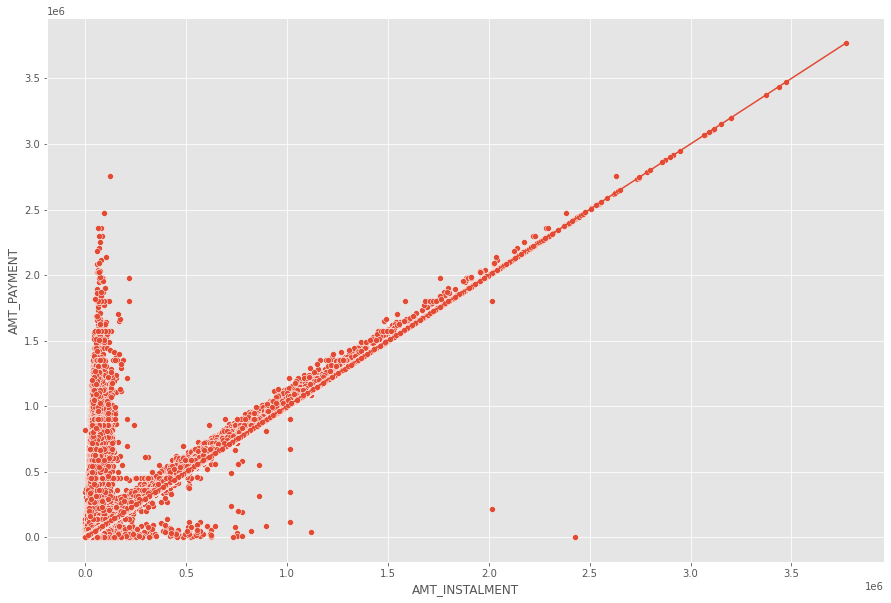

In [ ]:
sns.scatterplot(install_pmts.AMT_INSTALMENT, install_pmts.AMT_PAYMENT)
sns.lineplot([0, max(install_pmts.AMT_INSTALMENT)], [0, max(install_pmts.AMT_PAYMENT)])


In [ ]:
print(len(install_pmts[install_pmts.AMT_PAYMENT >= install_pmts.AMT_INSTALMENT]) / len(install_pmts) )
print(len(install_pmts[install_pmts.AMT_PAYMENT < install_pmts.AMT_INSTALMENT]) / len(install_pmts) )

0.9045674581734121
0.09521902368037517


<AxesSubplot:xlabel='AMT_PAYMENT', ylabel='Count'>

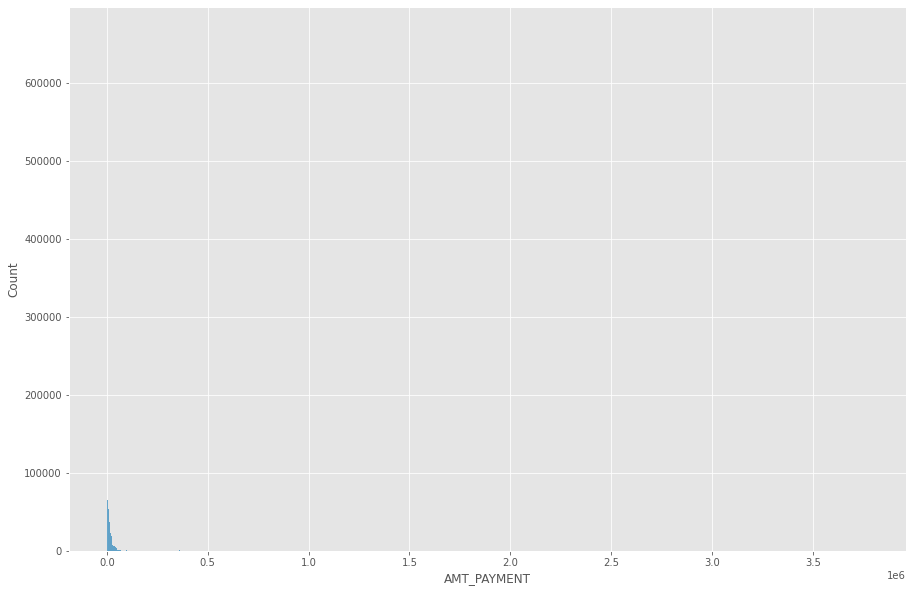

In [ ]:
sns.histplot(install_pmts.AMT_PAYMENT)

<AxesSubplot:ylabel='Count'>

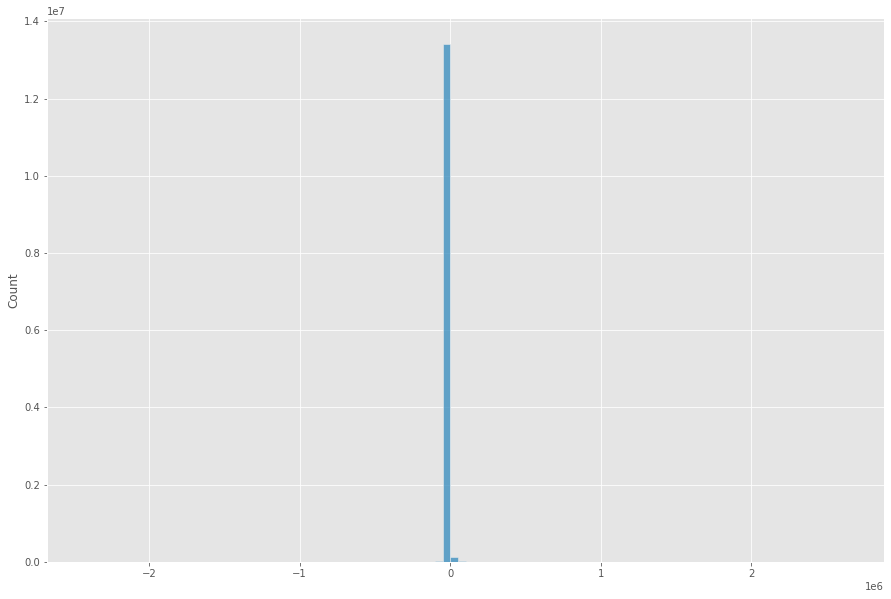

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
# sns.histplot(install_pmts.AMT_PAYMENT - install_pmts.AMT_INSTALMENT, bins = 100 )

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='AMT_INSTALMENT'>

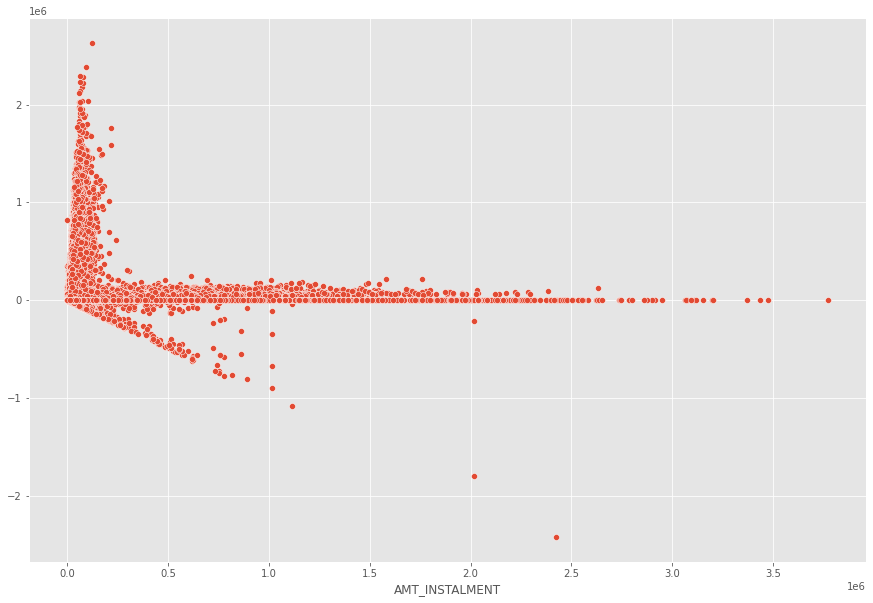

In [ ]:
sns.scatterplot(install_pmts.AMT_INSTALMENT, install_pmts.AMT_PAYMENT - install_pmts.AMT_INSTALMENT)


In [ ]:
install_pmts[install_pmts.AMT_PAYMENT == 0].SK_ID_CURR.value_counts()

168723    5
358084    4
449675    4
155925    4
296887    4
         ..
296114    1
442415    1
324644    1
322322    1
249455    1
Name: SK_ID_CURR, Length: 1098, dtype: int64

In [ ]:
missed_pmts = pd.DataFrame(install_pmts[install_pmts.AMT_PAYMENT == 0].SK_ID_CURR.value_counts()).reset_index()
missed_pmts.columns = ["SK_ID_CURR", "Pmts_Missed"]
missed_pmts

,SK_ID_CURR,Pmts_Missed
0,168723,5
1,358084,4
2,449675,4
3,155925,4
4,296887,4
...,...,...
1093,296114,1
1094,442415,1
1095,324644,1
1096,322322,1


In [ ]:
missed_pmts[missed_pmts.Pmts_Missed > 1]

,SK_ID_CURR,Pmts_Missed
0,168723,5
1,358084,4
2,449675,4
3,155925,4
4,296887,4
...,...,...
254,392171,2
255,265342,2
256,453734,2
257,137552,2


In [ ]:
under_paid = pd.DataFrame(install_pmts[install_pmts.AMT_PAYMENT < install_pmts.AMT_INSTALMENT].SK_ID_CURR.value_counts()).reset_index()
under_paid

,index,SK_ID_CURR
0,421201,154
1,111752,143
2,441733,136
3,341119,135
4,437022,131
...,...,...
145331,112329,1
145332,244951,1
145333,342888,1
145334,431087,1


## Notes!!!:

- The previous loan information is likely linked via the previous ID number (SK_ID_PREV).
- Should be able to extract how much was paid out to the loan via the payments and the *installment_payments* datasets and compare that to the amount credit of the loan given in the *previous_applications* dataset
    - can find who either did not fully pay out the loan and by how much as well as any interest paid, if any.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9263f292-ea73-48e7-8892-f3d3ed1db03c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>